# New Lesson 3: Morphological Operations and Quantifications

So far we have learned how to find objects of interest in an image and produce masks which correspond to these objects. Until now, we have relied on image preprocessing to produce quality masks. However, in this session we plan to study morphological operations, which instead focus on making improvements to the masks directly.

1. In this module you will first learn
    1) What is a morphological operation
    2) How to choose the right parameters for your morphological operation
   Some common morphological operations:
    - Erosion
    - Dilation
    - Opening
    - Closing


2. To quantify the change in objects localization and their morphological variations.
    
    This section requires care when choosing the preprocessing algorithms to apply and their ordering, as well as batch processing across datasets.

3. Access properties of cells that have been detected, such as
    - Area
    - Intensity
    - Image vs mask properties
    - Aspect ratio
    
   View the statistics of properties of detected cells;
   Filter out unwanted cells based on their properties

***
## 3.1 Load previously processed data (filter and thresholding)

### 3.1.1 Load, understand and visualize the data

First, let's import packages and set some plotting defaults


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage
import seaborn as sns
import os


### 3.1.2 Load the images


#### <font color='red'> Exercise</font>: load lesson 3 data  
Use what you learned in Lesson 1 and 2 to load the Lesson 3 image data. 
Hint:   
Step 1) Find the data directory  
Step 2) use skimage.io.imread to load the image data  



In [2]:
data_path = '/Users/Ehsan/Documents/StanfordBIOS254-2019/Data/L3Data/'

In [3]:
from skimage.io import imread

data_fn = 'HAC-Cit-KRABdox_s41_t170.tif'
full_data_path = os.path.join(data_path, data_fn)
data = imread(full_data_path)

### 3.1.3 Load the metadata

Load the metadata, which is in JSON format

In [4]:
import json
metadata_fn = 'HAC-Cit-KRABdox_s41_t70.json'
with open(os.path.join(data_path, metadata_fn), mode='r') as metadata_ctl:
    meta_data = json.load(metadata_ctl)

In [5]:
slice = {}
for idx, channel in enumerate(meta_data['channels']):
    slice[channel] = data[:,:,idx]

In [6]:
brt_data = slice['DIC']
ch1_data = slice['YFP']
ch2_data = slice['RFP']

In [7]:
cha = ch1_data

In [8]:
def get_mask(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    return(mask)


### 3.1.4 Filtering and background subtraction

To illustrate the need for preprocessing, let's try to automatically threshold the fluorescent channel of our data.

In [9]:
from skimage.filters.rank import minimum as min_filter
from skimage.filters.rank import median as median_filter
from skimage.morphology import disk

In [10]:
f_size = 4
cha_filtered = median_filter(cha, disk(f_size))

In [11]:
filter_radius = 12
cha_background = min_filter(cha_filtered, disk(filter_radius))

Next, let's substract out the background from the dataset.

In [12]:
cha_bgs = cha_filtered - cha_background
cha_bgs[cha_bgs<0] = 0

In [13]:
from skimage.filters import threshold_otsu

thresh_otsu = threshold_otsu(cha_bgs)
mask_otsu = get_mask(cha_bgs, thresh_otsu)

Text(0.5, 1.0, 'Otsu threshold')

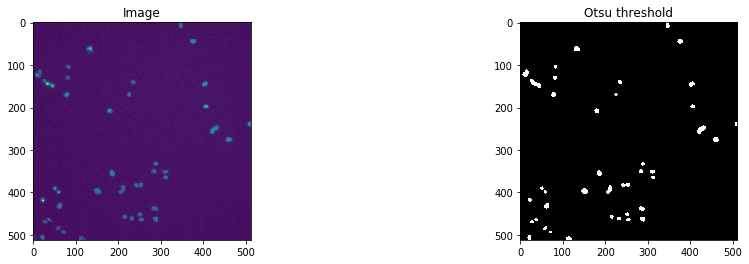

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].imshow(cha)
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, cmap='gray')
ax[1].set_title('Otsu threshold')

## 3.2 Morphological Operations

### 3.2.1 Pre-set

In [15]:
import skimage.morphology as sm
from skimage.measure import label

### 3.2.2 Optimized Operation Results (Closing-opening)

In [16]:
morph = sm.binary_erosion(mask_otsu,sm.disk(1.1))

In [17]:
cell_label_otsu = label(mask_otsu)
cell_num_otsu = np.amax(cell_label_otsu)

cell_label_morph=label(morph)
cell_num_morph = np.amax(cell_label_morph)


Plotting the data.

Text(660, 30, '41')

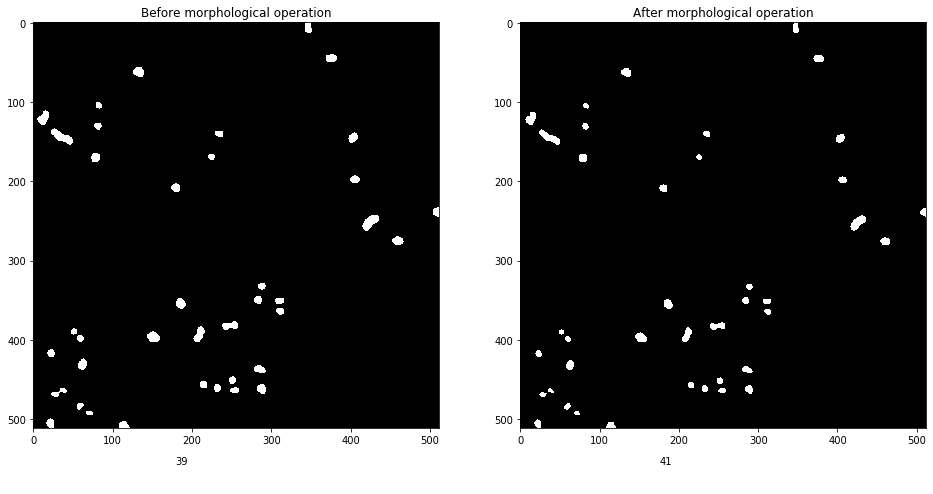

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mask_otsu, cmap='gray')
ax[0].set_title('Before morphological operation')
ax[0].annotate(cell_num_otsu,xy=(175, 30), xycoords='figure pixels')

ax[1].imshow(morph, cmap='gray')
ax[1].set_title('After morphological operation')
ax[1].annotate(cell_num_morph,xy=(660, 30), xycoords='figure pixels')

#### <font color='red'> Exercise</font>: Using For Loop investigate how the object number might change with disk size. 
Find an optimal range of disk value, and plot your findings. 

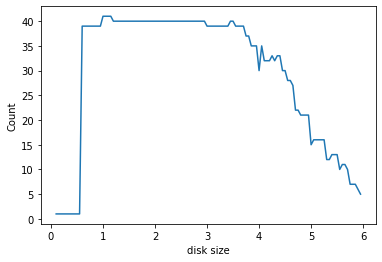

In [19]:
cellNum=[]
disk_siz=np.arange(0.1,6,0.05)
for i in disk_siz:
    morph = sm.binary_erosion(mask_otsu,sm.disk(i))
    cell_label_morph=label(morph)
    cell_num_morph= np.amax(cell_label_morph)
    cellNum.append(cell_num_morph)
    
plt.plot(disk_siz,cellNum)
plt.xlabel('disk size')
plt.ylabel('Count')
plt.show()


## 3.3 Quantifying Properties of Identified Regions or Cells


### 3.3.1. Load lable function and label cells with different colors

In [20]:
import matplotlib
morph = sm.binary_erosion(mask_otsu,sm.disk(1.1))# Restore the original value 1.1 for disk
cell_mask = morph
cell_labels = label(cell_mask)

cell_intensities = cha
cell_intensities[~cell_mask] = 0


Load regionprops function and get the properties of the labeled cells


In [21]:
from skimage.measure import regionprops
from matplotlib import cm


Plot labeled cells with different colors

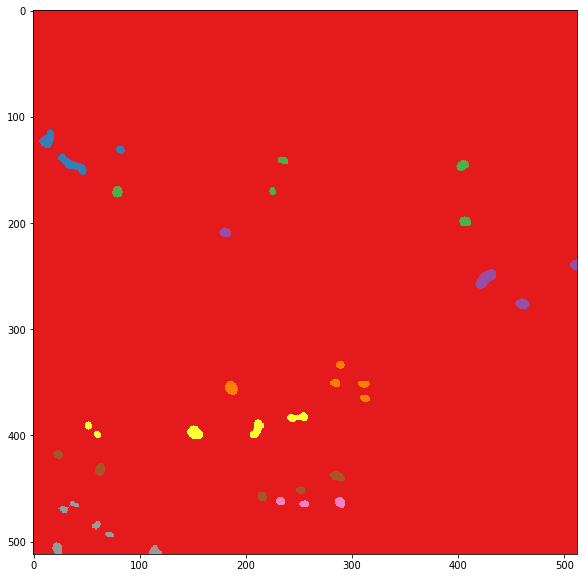

In [22]:
props = regionprops(cell_labels, cell_intensities)

category_cmap = cm.get_cmap('Set1', len(props))

fig, ax = plt.subplots(1, figsize=(10,10))
plt.imshow(cell_labels,cmap = category_cmap)

# 3.4 Measure properties of cells that have been detected

In [23]:
Centroid = []
for j in range(1,len(props)):
    props[j].centroid
    Centroid.append(props[j].centroid)
Cent_arr=np.array(Centroid)

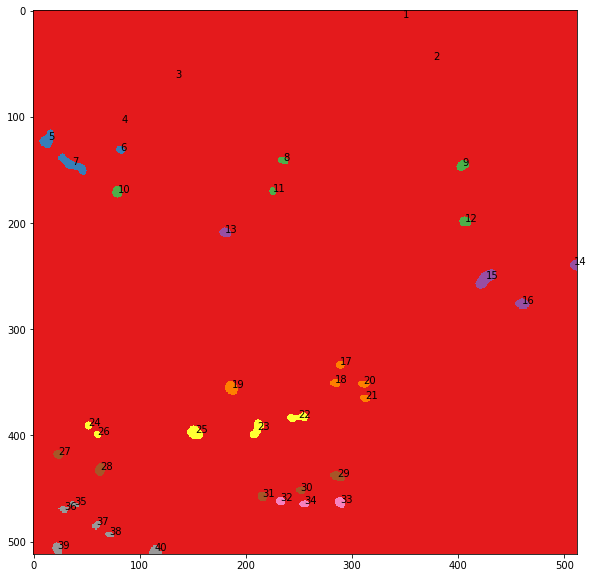

In [24]:
x = Cent_arr[:,0]
y = Cent_arr[:,1]
n=np.array(range(1,41))

fig, ax = plt.subplots(1, figsize=(10,10))
plt.imshow(cell_labels,cmap = category_cmap)

for i, txt in enumerate(n):
    ax.annotate(txt, (y[i], x[i]))

Area:

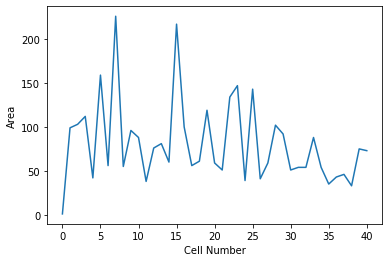

In [25]:
Area = []
for n in range(0,len(props)):
    props[n].area
    Area.append(props[n].area)
    
plt.plot(Area)
plt.xlabel('Cell Number')
plt.ylabel('Area')
plt.show()


Aspect Ratio

In [26]:
bounding_box = props[5].bbox
aspect_ratio = 1. * (bounding_box[3] - bounding_box[1]) / (bounding_box[2] - bounding_box[0])
print(aspect_ratio)

0.7777777777777778


Roundness

Estimate each object's area and perimeter. Use these results to form a simple metric indicating the roundness of an object:

metric=
4π∗area/perimeter^2

This metric is equal to 1 only for a circle and it is less than one for any other shape. The discrimination process can be controlled by setting an appropriate threshold

In [27]:
import math
Roundness= 4* math.pi*props[1].area/props[1].perimeter **2
print(Roundness)

0.8490682879800738
